## Imports & Settings

In [2]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
import matplotlib.pyplot as plt


import warnings

warnings.filterwarnings(action='ignore', category=UserWarning)


### Load & Inspect Data

In [3]:
df = pd.read_csv("heart[1].csv")

print(df.columns)
print(df.dtypes)
print(df.describe())
print(df.head())
print(df.isnull().sum())
print(df.shape)
df.columns=df.columns.str.strip()



Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  13

## Encode Categorical Variables

In [4]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

encode_data=pd.get_dummies(df,columns=cat_cols,drop_first=True)
x=encode_data.drop("HeartDisease",axis=1)
y=encode_data["HeartDisease"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)



## Grid Search for Hyperparameters

In [5]:
param_grid={"max_depth":range(2,10),
           "min_samples_leaf":range(2,10),
            "min_samples_split":range(2,5),
            "criterion":['gini','entropy']
           }

grid=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid,cv=5,scoring='accuracy')
grid.fit(x_train,y_train)

print("best params: ",grid.best_params_)
print("best score: ",grid.best_score_)

best params:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
best score:  0.8316618217054262


## Train Base Decision Tree

In [6]:

model=DecisionTreeClassifier(criterion='gini',max_depth=3,min_samples_leaf=2,min_samples_split=2,random_state=42)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.8405797101449275
Confusion Matrix:
 [[ 98  14]
 [ 30 134]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       112
           1       0.91      0.82      0.86       164

    accuracy                           0.84       276
   macro avg       0.84      0.85      0.84       276
weighted avg       0.85      0.84      0.84       276



## Cost Complexity Pruning

In [7]:
full_tree=DecisionTreeClassifier(random_state=42)
full_tree.fit(x_train,y_train)
path=full_tree.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas=path.ccp_alphas

best_score=0
best_alpha=0
for alpha in ccp_alphas:
    clf=DecisionTreeClassifier(random_state=42,ccp_alpha=alpha)
    clf.fit(x_train,y_train)
    scores=cross_val_score(clf,x_train,y_train,cv=5)
    score=scores.mean()
    if score>best_score:
        best_score=score
        best_alpha=alpha

print("best acuraccy:",best_score)
print("best alpha: ",best_alpha)




best acuraccy: 0.8254602713178294
best alpha:  0.005090120160213617


## Train Pruned Tree

Accuracy: 0.8115942028985508
Confusion Matrix:
 [[ 99  13]
 [ 39 125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       112
           1       0.91      0.76      0.83       164

    accuracy                           0.81       276
   macro avg       0.81      0.82      0.81       276
weighted avg       0.83      0.81      0.81       276



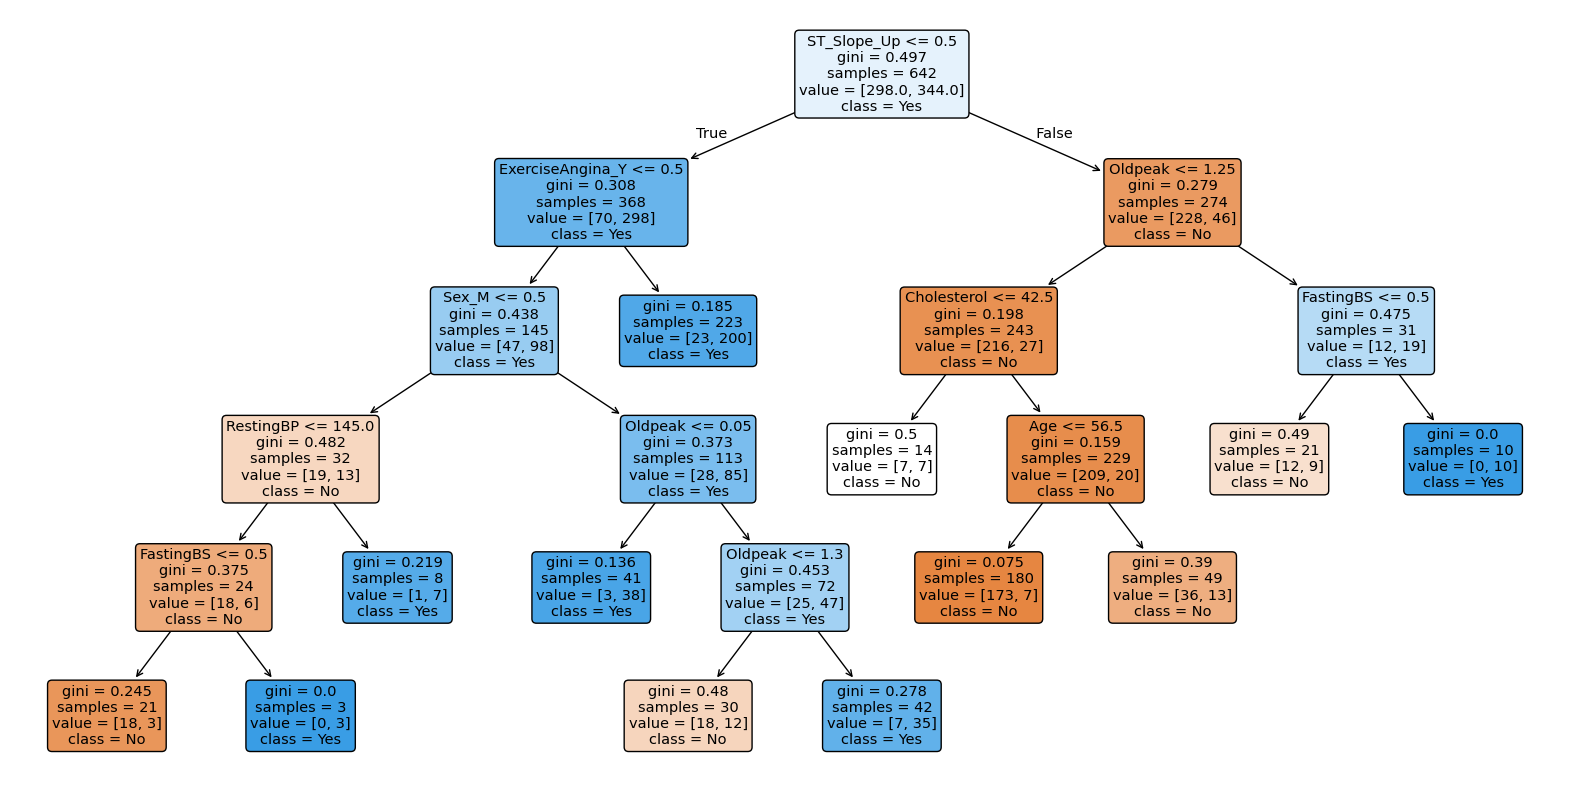

In [11]:
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(x_train, y_train)

y_pred_pruned = pruned_tree.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_pruned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_pruned))
print("Classification Report:\n", classification_report(y_test, y_pred_pruned))

plt.figure(figsize=(20,10))
plot_tree(pruned_tree, feature_names=x.columns, class_names=['No','Yes'], filled=True, rounded=True)
plt.show()


## Predict New User Input

In [12]:

def predict_user_sample(pruned_tree,x_columns):
    user_input={
        "Age": int(input("Age: ")),
        "Sex": input("Sex (M/F): ").upper(),
        "ChestPainType": input("Chest Pain (ATA/NAP/ASY/TA): ").upper(),
        "RestingECG": input("RestingECG (Normal/ST/LVH): ").capitalize(),
        "Cholesterol": int(input("Cholesterol: ")),
        "FastingBS": int(input("FastingBS (0/1): ")),
        "RestingECG": input("RestingECG (Normal/ST/LVH): "),
        "MaxHR": int(input("MaxHR: ")),
        "ExerciseAngina": input("Exercise Angina (Y/N): ").upper(),
        "Oldpeak": float(input("Oldpeak: ")),
    "ST_Slope": input("ST Slope (Up/Flat/Down): ").capitalize()
    }
    user_df=pd.DataFrame([user_input])
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    user_encode=pd.get_dummies(user_df,columns=cat_cols,drop_first=True)
    user_aligned=user_encode.reindex(columns=x_columns,fill_value=0)
    predd=pruned_tree.predict(user_aligned)[0]
    
    print("\nPrediction:")
    print("⚠️ Heart Disease (1)" if predd==1 else "✔️ No Heart Disease (0)")
    return predd
    
    
predict_user_sample(pruned_tree, x.columns)



Age:  18
Sex (M/F):  m
Chest Pain (ATA/NAP/ASY/TA):  ATA
RestingECG (Normal/ST/LVH):  normal
Cholesterol:  132
FastingBS (0/1):  0
RestingECG (Normal/ST/LVH):  st
MaxHR:  120
Exercise Angina (Y/N):  y
Oldpeak:  0
ST Slope (Up/Flat/Down):  up



Prediction:
✔️ No Heart Disease (0)


0